In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import pickle
from imblearn.over_sampling import SMOTE

In [2]:
# Step 1: Data Loading
data = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')

/tmp/ipykernel_30/646637886.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')


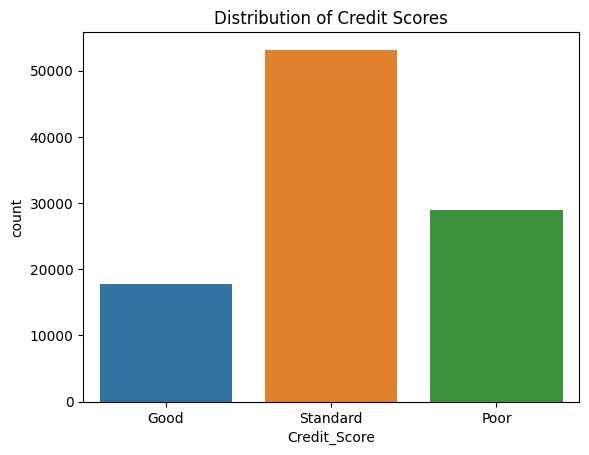

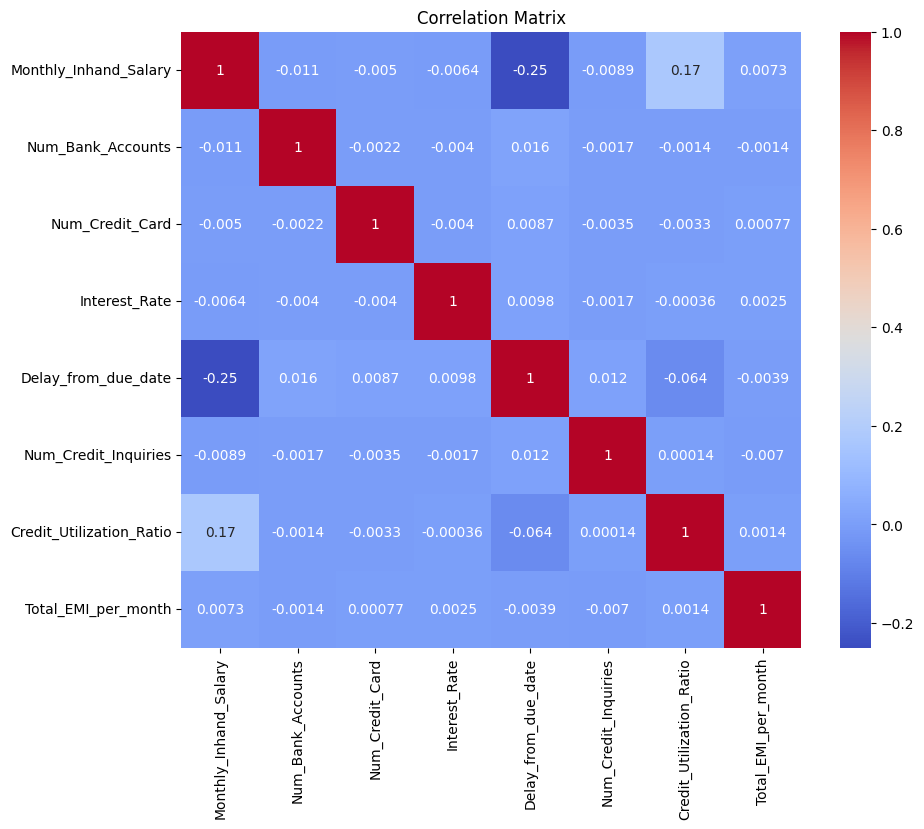

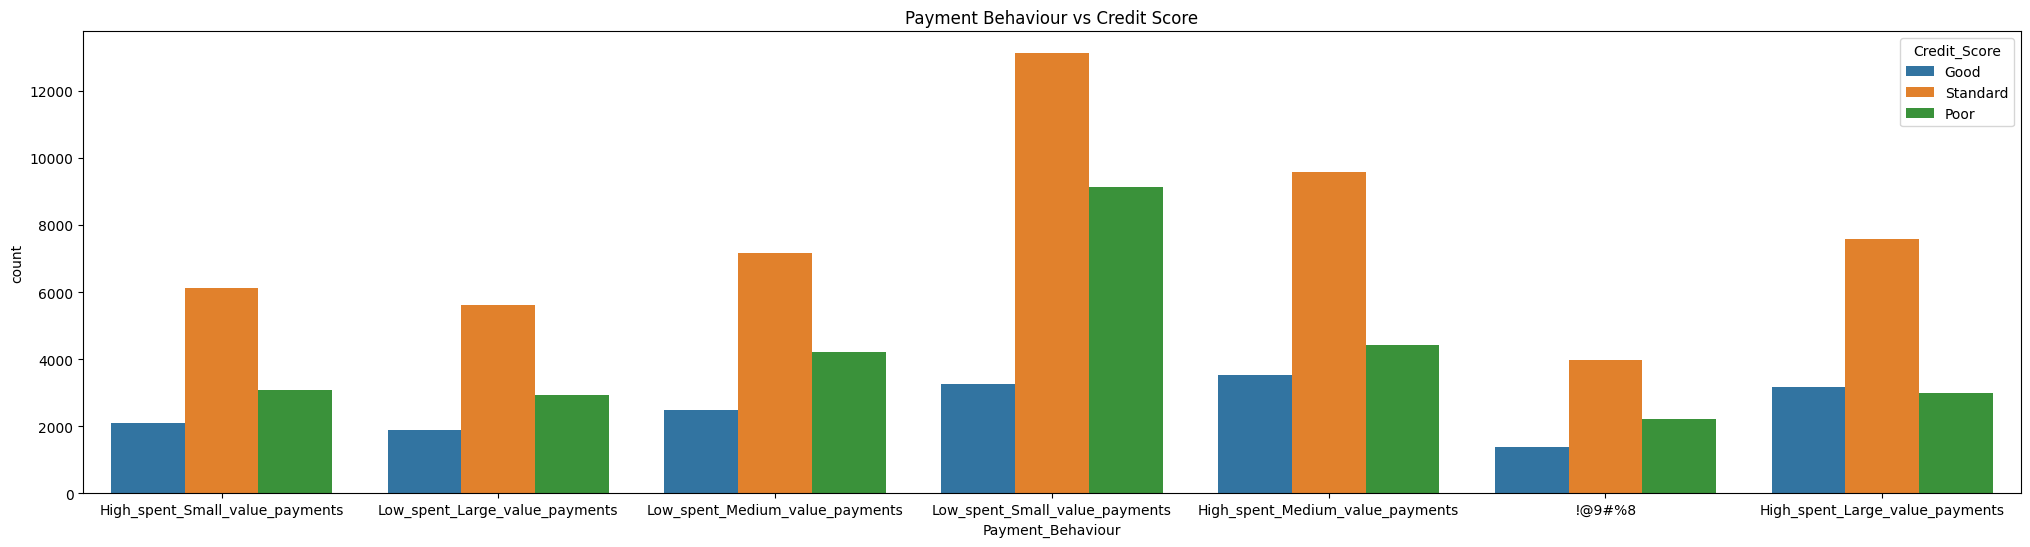

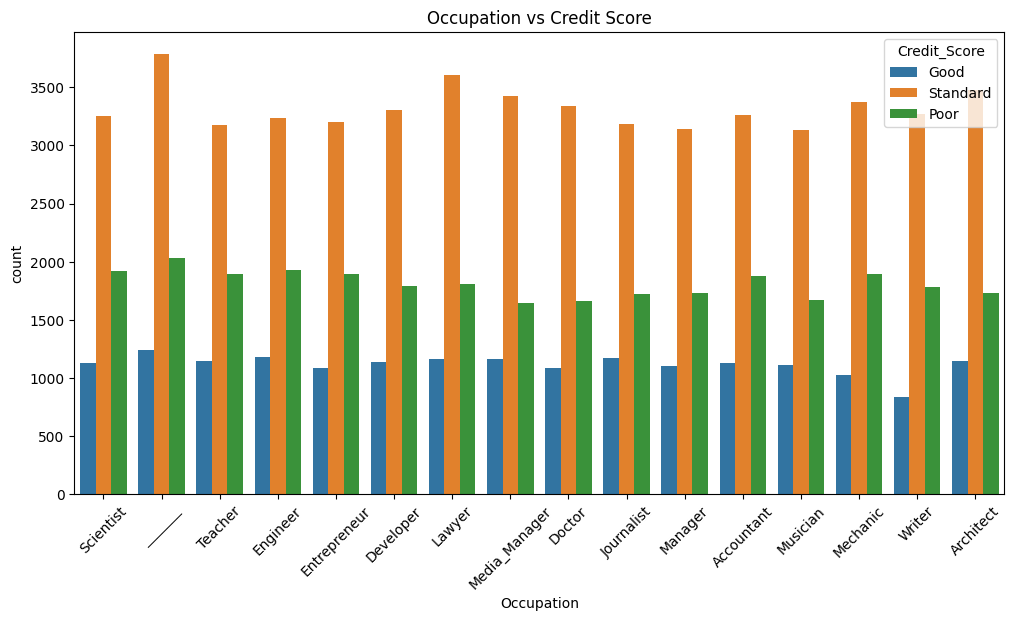

In [3]:
# Step 2: EDA
# Graph 1: Distribution of Credit Scores (Categorical plot)
sns.countplot(x='Credit_Score', data=data)
plt.title('Distribution of Credit Scores')
plt.show()

# Graph 2: Correlation Matrix (for numerical features only)
plt.figure(figsize=(10,8))
# Select only numerical columns for the correlation matrix
numerical_cols = data.select_dtypes(include=[np.number]).columns
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Graph 5: Categorical variable distribution - Payment Behaviour vs Credit Score
plt.figure(figsize=(25,6))
sns.countplot(x='Payment_Behaviour', hue='Credit_Score', data=data)
plt.title('Payment Behaviour vs Credit Score')
plt.show()

# Graph 6: Categorical variable distribution - Occupation vs Credit Score
plt.figure(figsize=(12,6))
sns.countplot(x='Occupation', hue='Credit_Score', data=data)
plt.title('Occupation vs Credit Score')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Step 3: Data Preprocessing
# Check for missing values
print(data.isnull().sum())

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64


In [5]:
categorical_cols = data.select_dtypes(include=['object']).columns

# Loop through each categorical column and print the unique values
for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(data[col].unique())
    print("\n")

Unique values in 'ID':
['0x1602' '0x1603' '0x1604' ... '0x25feb' '0x25fec' '0x25fed']


Unique values in 'Customer_ID':
['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c']


Unique values in 'Month':
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


Unique values in 'Name':
['Aaron Maashoh' nan 'Rick Rothackerj' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks']


Unique values in 'Age':
['23' '-500' '28_' ... '4808_' '2263' '1342']


Unique values in 'SSN':
['821-00-0265' '#F%$D@*&8' '004-07-5839' ... '133-16-7738' '031-35-0942'
 '078-73-5990']


Unique values in 'Occupation':
['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']


Unique values in 'Annual_Income':
['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_']


Unique values in 'Num_of_Loan':
['4' '1' '3' '967' '-100' '0' '0_' 

In [6]:
# Step 1: Handle missing values
# Impute numerical columns with the median value
numerical_cols = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')

for col in numerical_cols:
    data[col] = imputer.fit_transform(data[[col]])

# Impute categorical columns with the most frequent value
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

for col in categorical_cols:
    data[col] = categorical_imputer.fit_transform(data[[col]]).ravel()

In [7]:
# Step 2: Convert categorical variables to numerical values using manual mapping

# Credit Score (Assume mapping based on credit worthiness)
data['Credit_Score'] = data['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})

# Payment of Minimum Amount
data['Payment_of_Min_Amount'] = data['Payment_of_Min_Amount'].map({'No': 0, 'Yes': 1, 'NM': np.nan})  # 'NM' as missing

# Credit Mix (Good, Standard, Bad)
data['Credit_Mix'] = data['Credit_Mix'].replace('_', np.nan)
data['Credit_Mix'] = data['Credit_Mix'].map({'Bad': 0, 'Standard': 1, 'Good': 2})

# Payment Behaviour (Assume a custom mapping for different behavior types)
data['Payment_Behaviour'] = data['Payment_Behaviour'].map({
    'Low_spent_Large_value_payments': 0,
    'Low_spent_Medium_value_payments': 1,
    'Low_spent_Small_value_payments': 2,
    'High_spent_Small_value_payments': 3,
    'High_spent_Medium_value_payments': 4,
    'High_spent_Large_value_payments': 5,
    '!@9#%8': np.nan  # This looks like invalid data, treat as missing
})

# Type of Loan (Let's map different loan combinations to some custom numerical values)
# The mapping will depend on your understanding of loan types, here I'm making assumptions
data['Type_of_Loan'] = data['Type_of_Loan'].map({
    'Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan': 1,
    'Credit-Builder Loan': 2,
    'Auto Loan, Auto Loan, and Not Specified': 3,
    'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan': 4,
    'Payday Loan, Student Loan, Mortgage Loan, and Not Specified': 5,
    'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan': 6,
    np.nan: 0  # Treat missing loans as 0
})

# Occupation (Assigning numbers to different occupation types)
data['Occupation'] = data['Occupation'].map({
    'Scientist': 0, 'Teacher': 1, 'Engineer': 2, 'Entrepreneur': 3,
    'Developer': 4, 'Lawyer': 5, 'Media_Manager': 6, 'Doctor': 7,
    'Journalist': 8, 'Manager': 9, 'Accountant': 10, 'Musician': 11,
    'Mechanic': 12, 'Writer': 13, 'Architect': 14, '_______': np.nan  # Treat unknown as missing
})

# Month (Assuming chronological order of months)
data['Month'] = data['Month'].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8
})

# Convert 'Credit_History_Age' to numeric (extracting the number of years)
data['Credit_History_Age'] = data['Credit_History_Age'].str.extract(r'(\d+)').astype(float)

In [8]:
# Drop Not Needed Variables
data = data.drop(['ID', 'Customer_ID', 'Name', 'Age', 'SSN'], axis=1)


In [9]:
categorical_cols = data.select_dtypes(include=['object']).columns

# Loop through each categorical column and print the unique values
for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(data[col].unique())
    print("\n")

Unique values in 'Annual_Income':
['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_']


Unique values in 'Num_of_Loan':
['4' '1' '3' '967' '-100' '0' '0_' '2' '3_' '2_' '7' '5' '5_' '6' '8' '8_'
 '9' '9_' '4_' '7_' '1_' '1464' '6_' '622' '352' '472' '1017' '945' '146'
 '563' '341' '444' '720' '1485' '49' '737' '1106' '466' '728' '313' '843'
 '597_' '617' '119' '663' '640' '92_' '1019' '501' '1302' '39' '716' '848'
 '931' '1214' '186' '424' '1001' '1110' '1152' '457' '1433' '1187' '52'
 '1480' '1047' '1035' '1347_' '33' '193' '699' '329' '1451' '484' '132'
 '649' '995' '545' '684' '1135' '1094' '1204' '654' '58' '348' '614'
 '1363' '323' '1406' '1348' '430' '153' '1461' '905' '1312' '1424' '1154'
 '95' '1353' '1228' '819' '1006' '795' '359' '1209' '590' '696' '1185_'
 '1465' '911' '1181' '70' '816' '1369' '143' '1416' '455' '55' '1096'
 '1474' '420' '1131' '904' '89' '1259' '527' '1241' '449' '983' '418'
 '319' '23' '238' '638' '138' '235_' '280' '1070' '1484' '274

In [10]:
# Step 1: Clean variables by removing invalid characters and converting to numeric where necessary

# Remove underscores and convert to numeric for columns like 'Annual_Income', 'Num_of_Loan', etc.
data['Annual_Income'] = pd.to_numeric(data['Annual_Income'].str.replace('_', ''), errors='coerce')
data['Num_of_Loan'] = pd.to_numeric(data['Num_of_Loan'].str.replace('_', ''), errors='coerce')
data['Num_of_Delayed_Payment'] = pd.to_numeric(data['Num_of_Delayed_Payment'].str.replace('_', ''), errors='coerce')
data['Changed_Credit_Limit'] = pd.to_numeric(data['Changed_Credit_Limit'].str.replace('_', ''), errors='coerce')
data['Outstanding_Debt'] = pd.to_numeric(data['Outstanding_Debt'].str.replace('_', ''), errors='coerce')
data['Amount_invested_monthly'] = pd.to_numeric(data['Amount_invested_monthly'].str.replace('_', ''), errors='coerce')
data['Monthly_Balance'] = pd.to_numeric(data['Monthly_Balance'].str.replace('_', ''), errors='coerce')

# After cleaning, we can check if any values are still negative or unusual and handle them
# For example, replacing negative values with NaN for 'Num_of_Loan' and 'Num_of_Delayed_Payment'
data['Num_of_Loan'] = data['Num_of_Loan'].apply(lambda x: np.nan if x < 0 else x)
data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].apply(lambda x: np.nan if x < 0 else x)

# Step 2: Recheck missing values after cleaning
print(data.isnull().sum())

# Step 3: Handle missing values (using imputation as an example)

# Impute numerical columns with the median value for missing data
numerical_cols = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')

for col in numerical_cols:
    data[col] = imputer.fit_transform(data[[col]])

# Step 4: Final verification of data cleaning
print("Data types and first few rows after cleaning:")
print(data.dtypes)
print(data.head())


Month                           0
Occupation                   7062
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                  3876
Type_of_Loan                98648
Delay_from_due_date             0
Num_of_Delayed_Payment        644
Changed_Credit_Limit         2091
Num_Credit_Inquiries            0
Credit_Mix                  20195
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age              0
Payment_of_Min_Amount       12007
Total_EMI_per_month             0
Amount_invested_monthly         0
Payment_Behaviour            7600
Monthly_Balance              1668
Credit_Score                    0
dtype: int64
Data types and first few rows after cleaning:
Month                       float64
Occupation                  float64
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accoun

In [11]:
# Step 4: Outliers Analysis
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 5: Handle Class Imbalance (If imbalance found)
data['Credit_Score'] = data['Credit_Score'].astype(int)
X = data.drop('Credit_Score', axis=1)
y = data['Credit_Score']
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)


# Step 6: Feature Selection (Top 10 features)
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X_res, y_res)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 13] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [12]:
# Get the mask of selected features
selected_features_mask = selector.get_support()

# Get the original column names of X_res
selected_columns = X_res.columns[selected_features_mask]

# Print the names of the selected features
print("Selected features:", selected_columns)

Selected features: Index(['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
       'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount'],
      dtype='object')


In [13]:
print(X_res[selected_columns])

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0               2.000000         5.000000       4.000000     1.000000   
1               7.000000         5.000000       5.000000     0.000000   
2               7.000000         5.000000       5.000000     0.000000   
3               7.000000         5.000000       5.000000     3.000000   
4               7.000000         5.000000       5.000000     0.000000   
...                  ...              ...            ...          ...   
75802           5.653429         3.000000       7.960286     3.000000   
75803           0.977499         6.244375       3.710623     1.244375   
75804           5.159330         7.000000       5.460168     1.000000   
75805           4.150111         3.200148      13.599705     6.050037   
75806           2.000000         1.000000       8.000000     3.000000   

       Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
0                 5.000000                6.000

In [14]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_res, test_size=0.3, random_state=42)

In [15]:
# Apply scaling to both train and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Save the scaler as a pickle object
scaler_filename = "scaler.pkl"
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Scaler has been saved as {scaler_filename}")

Scaler has been saved as scaler.pkl


In [16]:
# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increase max_iter to address convergence warning
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Step 3: Train and evaluate models on scaled data
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"{name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

Logistic Regression:
Accuracy: 0.67
Recall: 0.67
F1 Score: 0.67
Precision: 0.68
Confusion Matrix:
 [[5756  992  753]
 [1184 4652 1808]
 [ 291 2424 4883]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78      7501
           1       0.58      0.61      0.59      7644
           2       0.66      0.64      0.65      7598

    accuracy                           0.67     22743
   macro avg       0.68      0.67      0.67     22743
weighted avg       0.68      0.67      0.67     22743



Random Forest:
Accuracy: 0.89
Recall: 0.89
F1 Score: 0.88
Precision: 0.89
Confusion Matrix:
 [[6403  546  552]
 [ 707 6562  375]
 [  51  381 7166]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      7501
           1       0.88      0.86      0.87      7644
           2       0.89      0.94      0.91      7598

    accuracy                           0.89     2

Ensemble Model (Voting Classifier):
Accuracy: 0.88
Recall: 0.88
F1 Score: 0.88
Precision: 0.88
Confusion Matrix:
 [[6383  525  593]
 [ 746 6556  342]
 [ 115  435 7048]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      7501
           1       0.87      0.86      0.86      7644
           2       0.88      0.93      0.90      7598

    accuracy                           0.88     22743
   macro avg       0.88      0.88      0.88     22743
weighted avg       0.88      0.88      0.88     22743



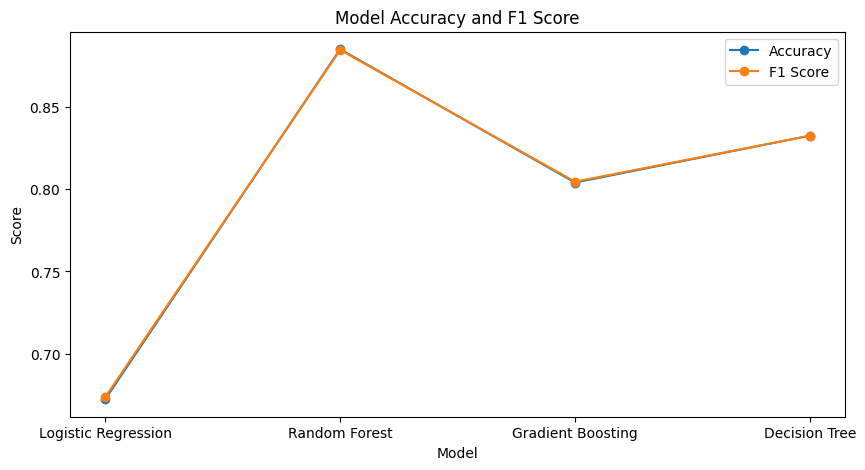

In [17]:
# Step 8: Ensemble Model (Combining Top 3 Classifiers)
voting_clf = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('dt', DecisionTreeClassifier())], voting='hard')

voting_clf.fit(X_train_scaled, y_train)
y_pred_ensemble = voting_clf.predict(X_test_scaled)

# Print ensemble model results
print("Ensemble Model (Voting Classifier):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_ensemble, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_ensemble, average='weighted'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble, average='weighted'):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

# Step 9: Plotting Accuracy and F1 Score
accuracies = [accuracy_score(y_test, models[name].predict(X_test_scaled)) for name in models]
f1_scores = [f1_score(y_test, models[name].predict(X_test_scaled), average='weighted') for name in models]

plt.figure(figsize=(10,5))
plt.plot(list(models.keys()), accuracies, marker='o', label='Accuracy')
plt.plot(list(models.keys()), f1_scores, marker='o', label='F1 Score')
plt.title('Model Accuracy and F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()
plt.show()

with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)